In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

import shap

In [5]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task1_10f.csv'
df = pd.read_csv(path)

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


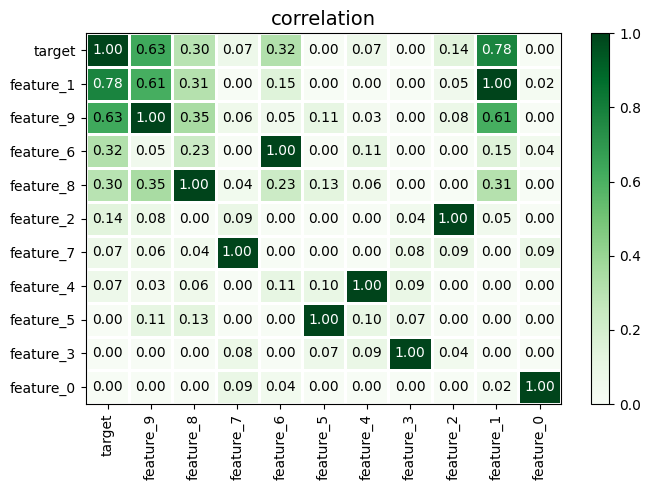

In [14]:
phik_overview = df.phik_matrix().round(2).sort_values('target')
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens')

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


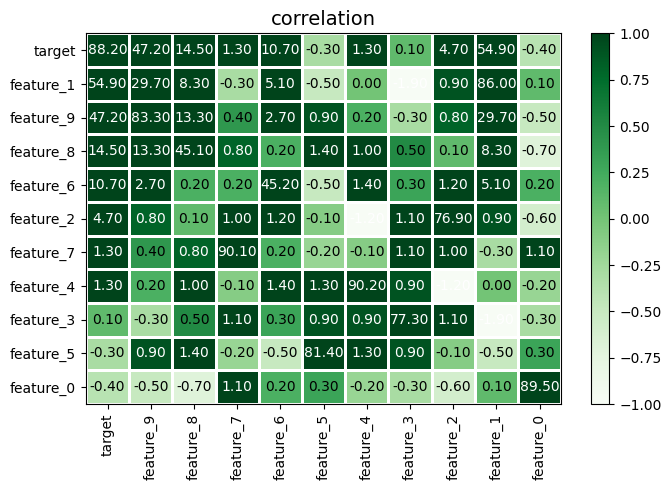

In [18]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target')
plot_correlation_matrix(significance_overview.values, x_labels=significance_overview.columns, y_labels=significance_overview.index, color_map='Greens')

In [19]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [20]:
drop_cols = ['target']
X = df.drop(columns=drop_cols)
y = df['target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [26]:
model = CatBoostClassifier(random_state=42)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, plot=False, early_stopping_rounds=50)

Learning rate set to 0.10885
0:	learn: 1.9397215	test: 1.9473294	best: 1.9473294 (0)	total: 79.4ms	remaining: 1m 19s
100:	learn: 0.4678663	test: 0.6483020	best: 0.6483020 (100)	total: 1.04s	remaining: 9.24s
200:	learn: 0.3304501	test: 0.6373796	best: 0.6366906 (199)	total: 1.99s	remaining: 7.93s
300:	learn: 0.2467960	test: 0.6428317	best: 0.6361299 (254)	total: 2.93s	remaining: 6.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6361299133
bestIteration = 254

Shrink model to first 255 iterations.


In [27]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,feature_1,32.490151
1,feature_9,29.112944
2,feature_8,12.172454
3,feature_2,4.631686
4,feature_6,4.100450
5,feature_7,3.807930
6,feature_5,3.795735
7,feature_4,3.491490
8,feature_3,3.473900
9,feature_0,2.923259


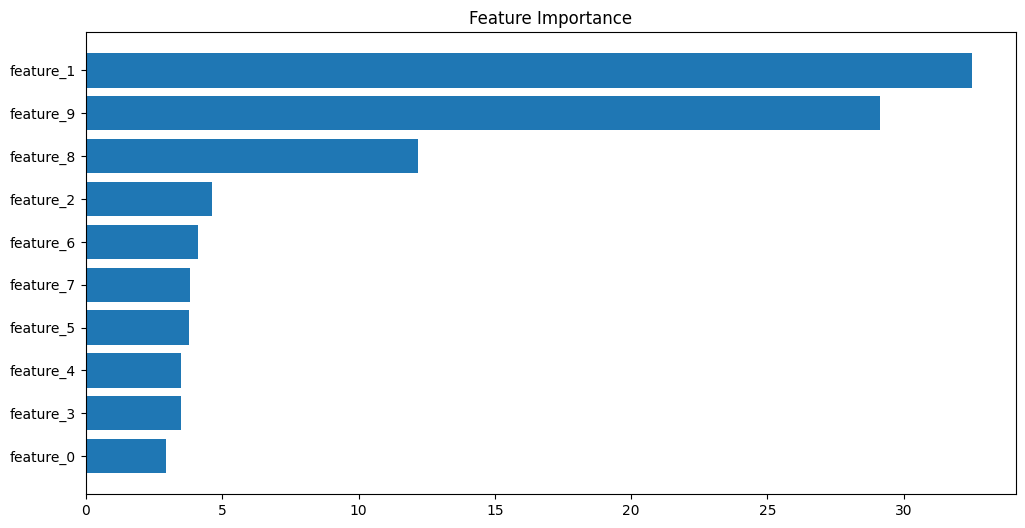

In [28]:
feature_imp = model.feature_importances_
sorted_idx = np.argsort(feature_imp)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [29]:
from sklearn.inspection import permutation_importance

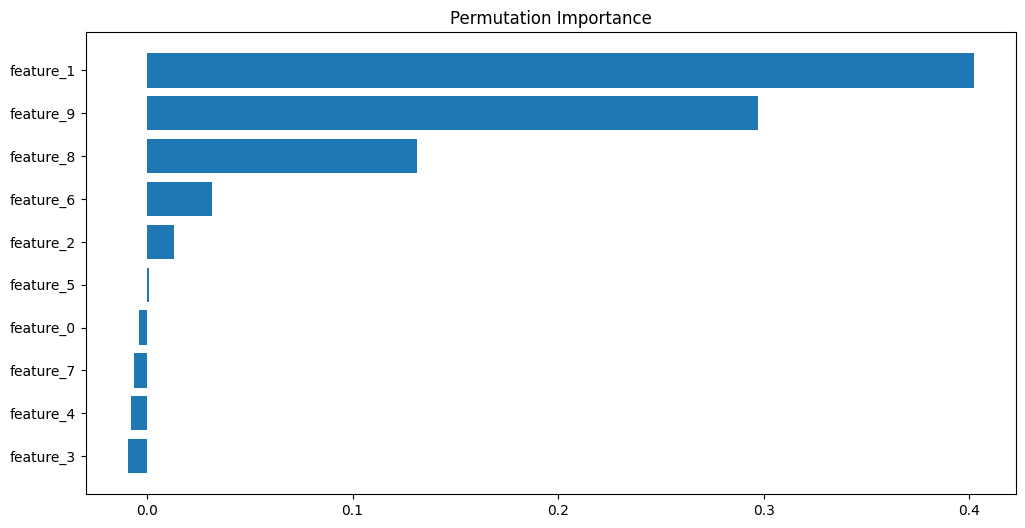

In [35]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [38]:
explainer = shap.TreeExplainer(model)

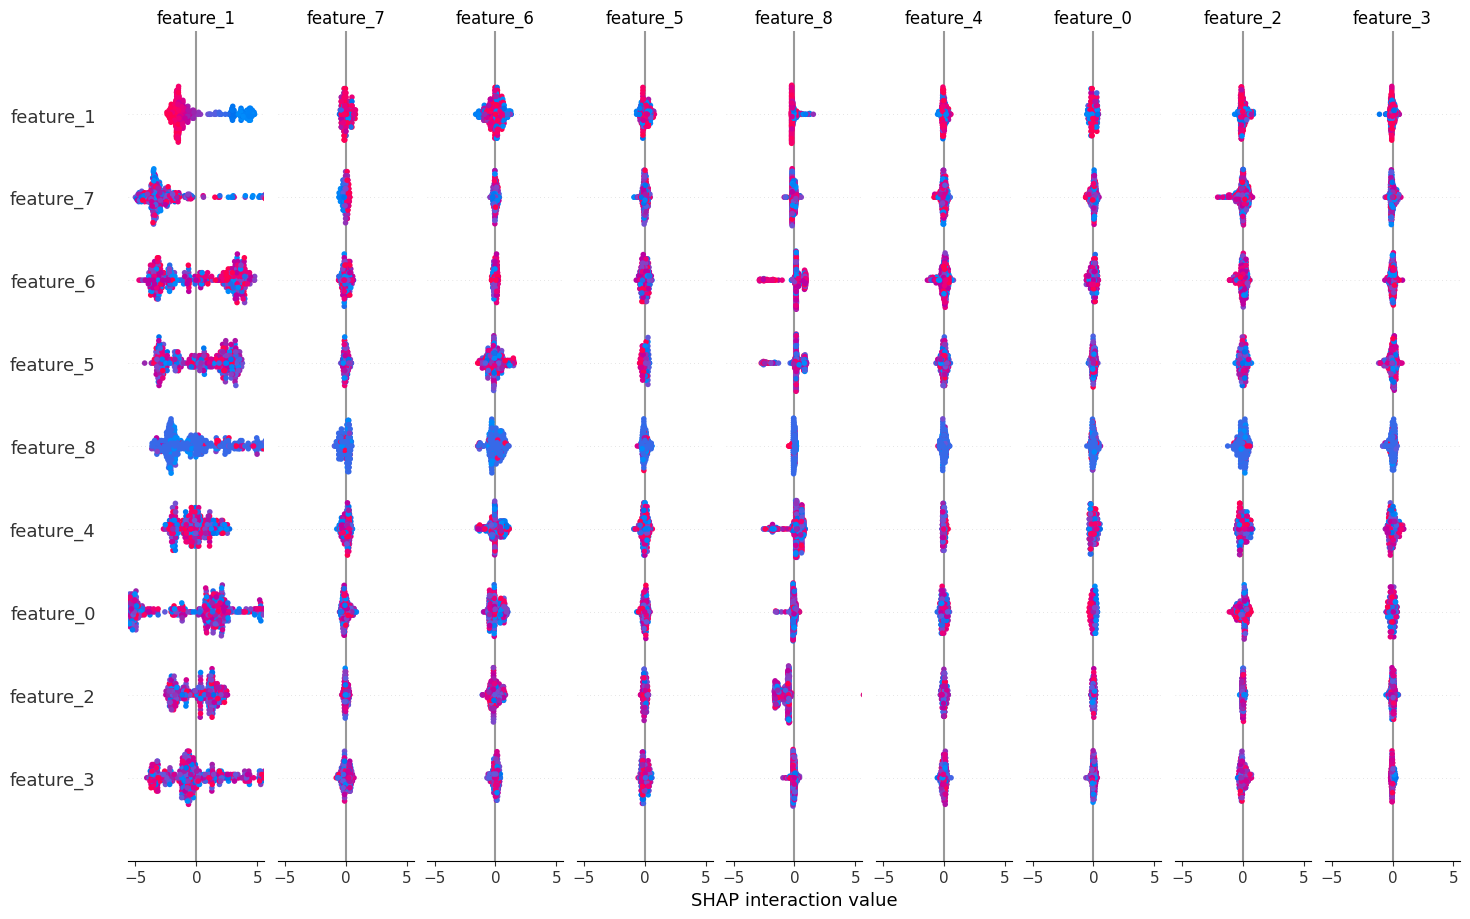

In [58]:
val_dataset = Pool(data=X_test, label=y_test)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=25)

In [48]:
model.select_features(X_train, y_train, eval_set=(X_test, y_test), features_for_select='0-8', num_features_to_select=8, train_final_model=False, logging_level='Silent', steps=1)

{'selected_features': [0, 1, 2, 3, 5, 6, 7, 8],
 'eliminated_features_names': ['feature_4'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1],
  'loss_values': [0.6361299132602128, 0.6262806907485204]},
 'eliminated_features': [4],
 'selected_features_names': ['feature_0',
  'feature_1',
  'feature_2',
  'feature_3',
  'feature_5',
  'feature_6',
  'feature_7',
  'feature_8']}

In [49]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [50]:
forest = RandomForestClassifier(max_depth=3)
boruta = BorutaPy(estimator=forest, n_estimators='auto', max_iter=8, verbose=1)
boruta.fit(X_train.values, y_train.values)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	5
Rejected: 	5


BorutaPy(estimator=RandomForestClassifier(max_depth=3, n_estimators=149,
                                          random_state=RandomState(MT19937) at 0x7059684F7440),
         max_iter=8, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7059684F7440, verbose=1)

In [56]:
green = X_train.columns[boruta.support_].tolist()
blue = X_train.columns[boruta.support_weak_].tolist()
red = X_train.columns[~(boruta.support_ | boruta.support_weak_)].tolist()
print('green: ', green)
print('blue: ', blue)
print('red: ', red)

green:  []
blue:  ['feature_1', 'feature_2', 'feature_6', 'feature_8', 'feature_9']
red:  ['feature_0', 'feature_3', 'feature_4', 'feature_5', 'feature_7']


In [52]:
boruta.*_?

boruta.__class__
boruta.__delattr__
boruta.__dict__
boruta.__dir__
boruta.__doc__
boruta.__eq__
boruta.__format__
boruta.__ge__
boruta.__getattribute__
boruta.__getstate__
boruta.__gt__
boruta.__hash__
boruta.__init__
boruta.__init_subclass__
boruta.__le__
boruta.__lt__
boruta.__module__
boruta.__ne__
boruta.__new__
boruta.__reduce__
boruta.__reduce_ex__
boruta.__repr__
boruta.__setattr__
boruta.__setstate__
boruta.__sizeof__
boruta.__sklearn_clone__
boruta.__str__
boruta.__subclasshook__
boruta.__version__
boruta.__weakref__
boruta.importance_history_
boruta.n_features_
boruta.ranking_
boruta.support_
boruta.support_weak_

### Найди рандомные фичи в датасете*

In [60]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task2_22f.csv'
df = pd.read_csv(path)

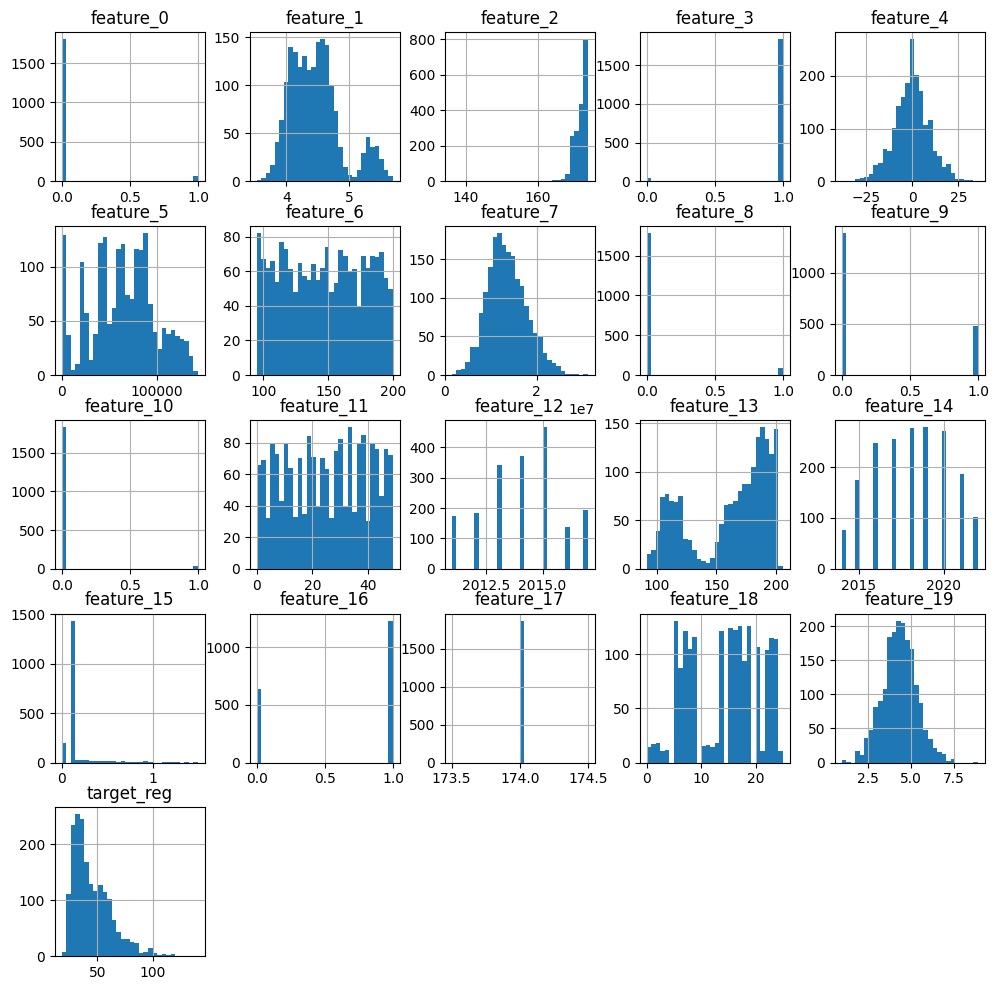

In [64]:
df.hist(figsize=(12,12), bins=30);

In [73]:
df_mod = df.drop(columns=['feature_17'])

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_18', 'feature_19', 'target_reg']


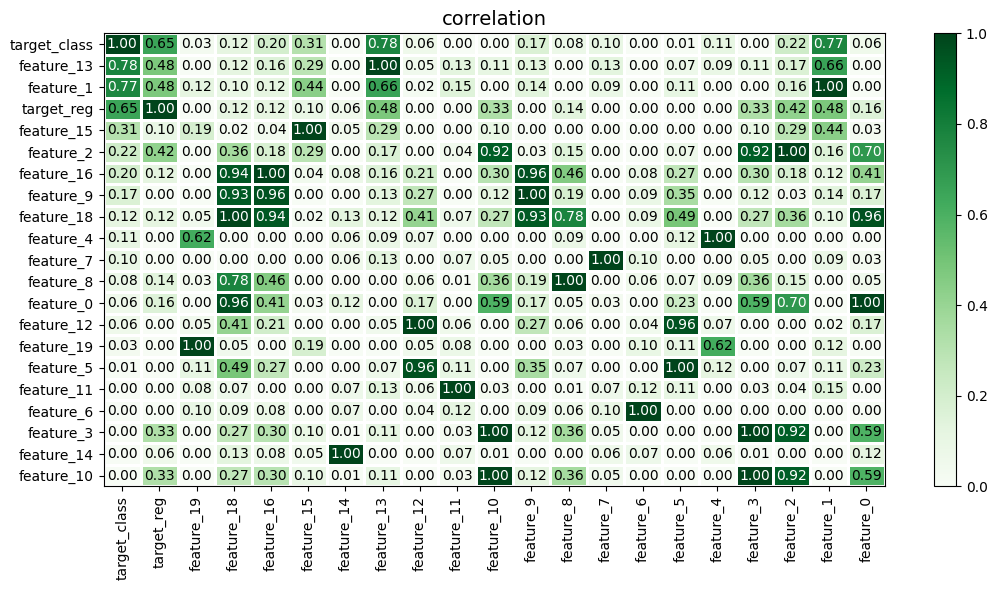

In [78]:
mtx_cls_phik = df_mod.phik_matrix().round(2).sort_values('target_class')
plot_correlation_matrix(mtx_cls_phik.values, x_labels=mtx_cls_phik.columns, y_labels=mtx_cls_phik.index, vmin=0, vmax=1, color_map='Greens', figsize=(11,6))
plt.tight_layout()

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_18', 'feature_19', 'target_reg']


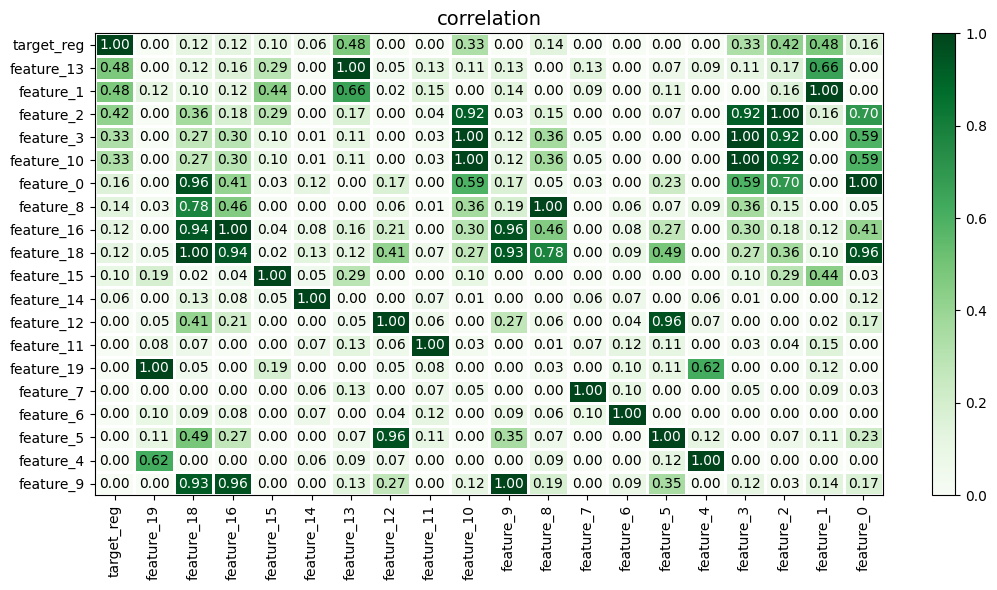

In [81]:
phik_overview_reg = df_mod.drop(columns='target_class').phik_matrix().round(2).sort_values('target_reg')
plot_correlation_matrix(phik_overview_reg.values, x_labels=phik_overview_reg.columns, y_labels=phik_overview_reg.index, vmin=0, vmax=1, figsize=(11,6), color_map='Greens')

In [82]:
mtx_cls_phik = df_mod.drop(columns='target_reg').significance_matrix().round(2).sort_values('target_class')

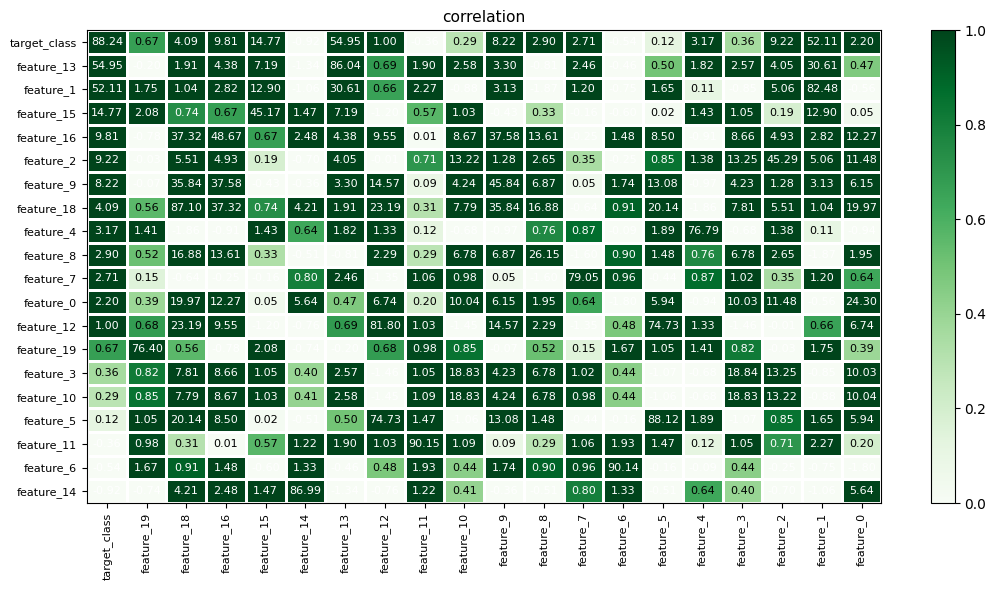

In [83]:
plot_correlation_matrix(mtx_cls_phik.values, x_labels=mtx_cls_phik.columns, y_labels=mtx_cls_phik.index, vmin=0, vmax=1, color_map='Greens', figsize=(11,6), fontsize_factor=.8)
plt.tight_layout()

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_18', 'feature_19', 'target_reg']


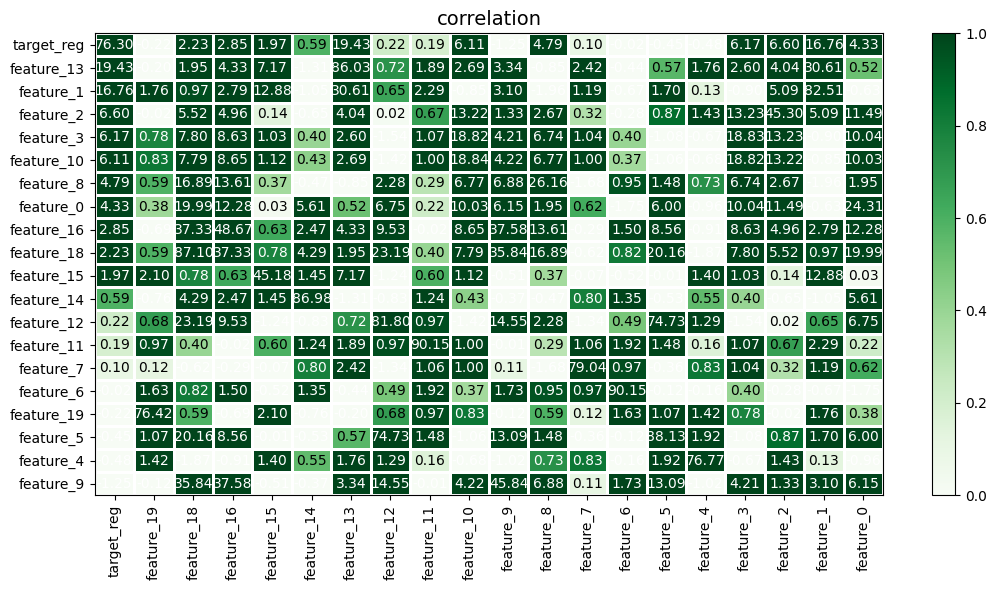

In [84]:
phik_overview_reg = df_mod.drop(columns='target_class').significance_matrix().round(2).sort_values('target_reg')
plot_correlation_matrix(phik_overview_reg.values, x_labels=phik_overview_reg.columns, y_labels=phik_overview_reg.index, vmin=0, vmax=1, figsize=(11,6), color_map='Greens')

In [95]:
X = df.drop(columns=['feature_17', 'target_reg', 'target_class'])
y_cl = df[['target_reg', 'target_class']]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y.target_class)

In [96]:
model_cat = CatBoostClassifier(random_state=42)
model_cat.fit(X_train, y_train.target_class, eval_set=(X_test, y_test.target_class), verbose=100, early_stopping_rounds=50, plot=False)

Learning rate set to 0.10885
0:	learn: 1.8818716	test: 1.8931525	best: 1.8931525 (0)	total: 37.2ms	remaining: 37.1s
100:	learn: 0.3677584	test: 0.5143939	best: 0.5143939 (100)	total: 1.22s	remaining: 10.9s
200:	learn: 0.2458526	test: 0.5016884	best: 0.5016884 (200)	total: 2.4s	remaining: 9.54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4974286413
bestIteration = 243

Shrink model to first 244 iterations.


In [97]:
fi = model_cat.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,feature_13,31.280597
1,feature_1,30.729038
2,feature_15,12.848177
3,feature_2,3.470514
4,feature_4,3.134723
5,feature_6,2.800037
6,feature_5,2.595735
7,feature_19,2.593143
8,feature_11,2.234084
9,feature_7,2.028427


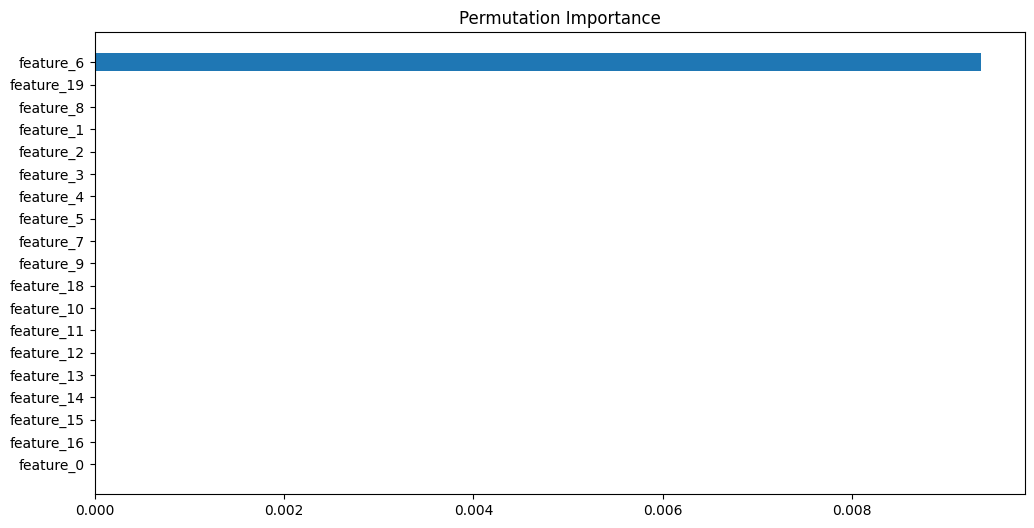

In [107]:
pi = permutation_importance(model, X_test, y_test.target_class, n_repeats=10, random_state=42)
sorted_idx = pi.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), pi.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

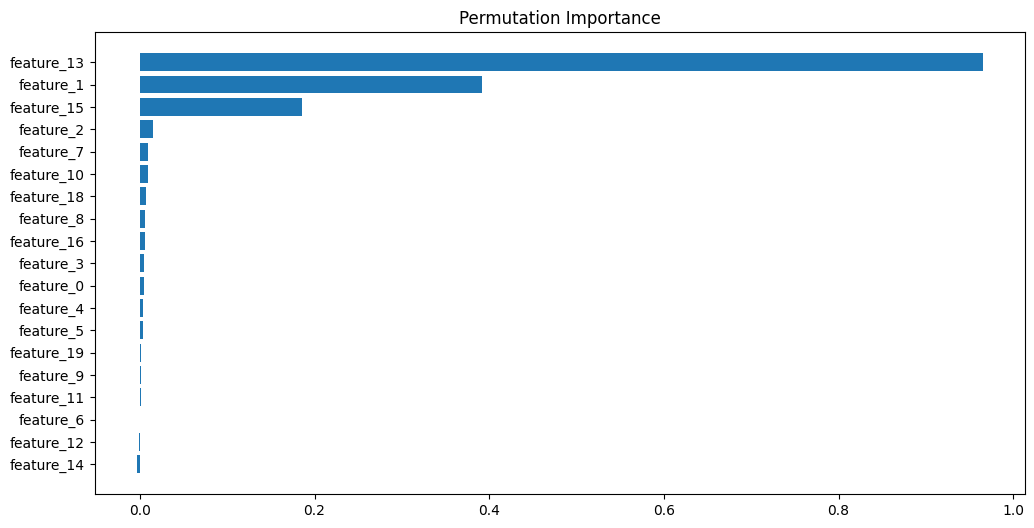

In [125]:
pi = permutation_importance(model_reg, X_test, y_test.target_reg, n_repeats=10, random_state=42)
sorted_idx = pi.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), pi.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

In [114]:
model_cat.select_features(X_train, y_train.target_class, eval_set=(X_test, y_test.target_class), features_for_select='0-18', train_final_model=False, logging_level='Silent', num_features_to_select=18)

{'selected_features': [0,
  1,
  2,
  3,
  4,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18],
 'eliminated_features_names': ['feature_6'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1],
  'loss_values': [0.4929388052883151, 0.48633475866186315]},
 'eliminated_features': [6],
 'selected_features_names': ['feature_0',
  'feature_1',
  'feature_2',
  'feature_3',
  'feature_4',
  'feature_5',
  'feature_7',
  'feature_8',
  'feature_9',
  'feature_10',
  'feature_11',
  'feature_12',
  'feature_13',
  'feature_14',
  'feature_15',
  'feature_16',
  'feature_18',
  'feature_19']}

In [115]:
model_reg = CatBoostRegressor(random_state=42)

In [116]:
model_reg.fit(X_train, y_train.target_reg, verbose=100, plot=False, early_stopping_rounds=50, eval_set=(X_test, y_test.target_reg))

Learning rate set to 0.054245
0:	learn: 17.1596903	test: 16.6852398	best: 16.6852398 (0)	total: 2.86ms	remaining: 2.86s
100:	learn: 10.3906969	test: 11.7529218	best: 11.7507390 (99)	total: 216ms	remaining: 1.92s
200:	learn: 9.0644528	test: 11.6785107	best: 11.6609262 (177)	total: 392ms	remaining: 1.56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.66092623
bestIteration = 177

Shrink model to first 178 iterations.


In [117]:
model_reg.select_features(X_train, y_train.target_reg, eval_set=(X_test, y_test.target_reg), features_for_select='0-18', num_features_to_select=18, train_final_model=False, logging_level='Silent')

{'selected_features': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  15,
  16,
  17,
  18],
 'eliminated_features_names': ['feature_14'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1],
  'loss_values': [11.660926233711466, 11.622800850617478]},
 'eliminated_features': [14],
 'selected_features_names': ['feature_0',
  'feature_1',
  'feature_2',
  'feature_3',
  'feature_4',
  'feature_5',
  'feature_6',
  'feature_7',
  'feature_8',
  'feature_9',
  'feature_10',
  'feature_11',
  'feature_12',
  'feature_13',
  'feature_15',
  'feature_16',
  'feature_18',
  'feature_19']}

In [119]:
forest = RandomForestClassifier(max_depth=4)
boruta = BorutaPy(forest, n_estimators='auto', max_iter = 20, verbose=1)
boruta.fit(X_train.values, y_train.target_class.values)

Iteration: 1 / 20
Iteration: 2 / 20
Iteration: 3 / 20
Iteration: 4 / 20
Iteration: 5 / 20
Iteration: 6 / 20
Iteration: 7 / 20
Iteration: 8 / 20
Iteration: 9 / 20
Iteration: 10 / 20
Iteration: 11 / 20
Iteration: 12 / 20
Iteration: 13 / 20
Iteration: 14 / 20
Iteration: 15 / 20
Iteration: 16 / 20
Iteration: 17 / 20
Iteration: 18 / 20
Iteration: 19 / 20


BorutaPy finished running.

Iteration: 	20 / 20
Confirmed: 	6
Tentative: 	1
Rejected: 	12


BorutaPy(estimator=RandomForestClassifier(max_depth=4, n_estimators=93,
                                          random_state=RandomState(MT19937) at 0x7059684F7440),
         max_iter=20, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7059684F7440, verbose=1)

In [120]:
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

features in the green area: ['feature_1', 'feature_2', 'feature_4', 'feature_7', 'feature_13', 'feature_15']
features in the blue area: ['feature_16']
features in the red area: ['feature_0', 'feature_3', 'feature_5', 'feature_6', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_14', 'feature_18', 'feature_19']


In [122]:
forest_reg = RandomForestRegressor(max_depth=4)
boruta = BorutaPy(forest_reg, n_estimators='auto', max_iter=20, verbose=1)
boruta.fit(X_train.values, y_train.target_reg.values)

Iteration: 1 / 20
Iteration: 2 / 20
Iteration: 3 / 20
Iteration: 4 / 20
Iteration: 5 / 20
Iteration: 6 / 20
Iteration: 7 / 20
Iteration: 8 / 20
Iteration: 9 / 20
Iteration: 10 / 20
Iteration: 11 / 20
Iteration: 12 / 20
Iteration: 13 / 20
Iteration: 14 / 20
Iteration: 15 / 20
Iteration: 16 / 20
Iteration: 17 / 20
Iteration: 18 / 20
Iteration: 19 / 20


BorutaPy finished running.

Iteration: 	20 / 20
Confirmed: 	5
Tentative: 	1
Rejected: 	13


BorutaPy(estimator=RandomForestRegressor(max_depth=4, n_estimators=106,
                                         random_state=RandomState(MT19937) at 0x7059684F7440),
         max_iter=20, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7059684F7440, verbose=1)

In [123]:
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

features in the green area: ['feature_0', 'feature_1', 'feature_2', 'feature_13', 'feature_15']
features in the blue area: ['feature_7']
features in the red area: ['feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_14', 'feature_16', 'feature_18', 'feature_19']


/opt/anaconda/lib/python3.10/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable feature_17 for analysis 1. Dropping this column
  warnings.warn(


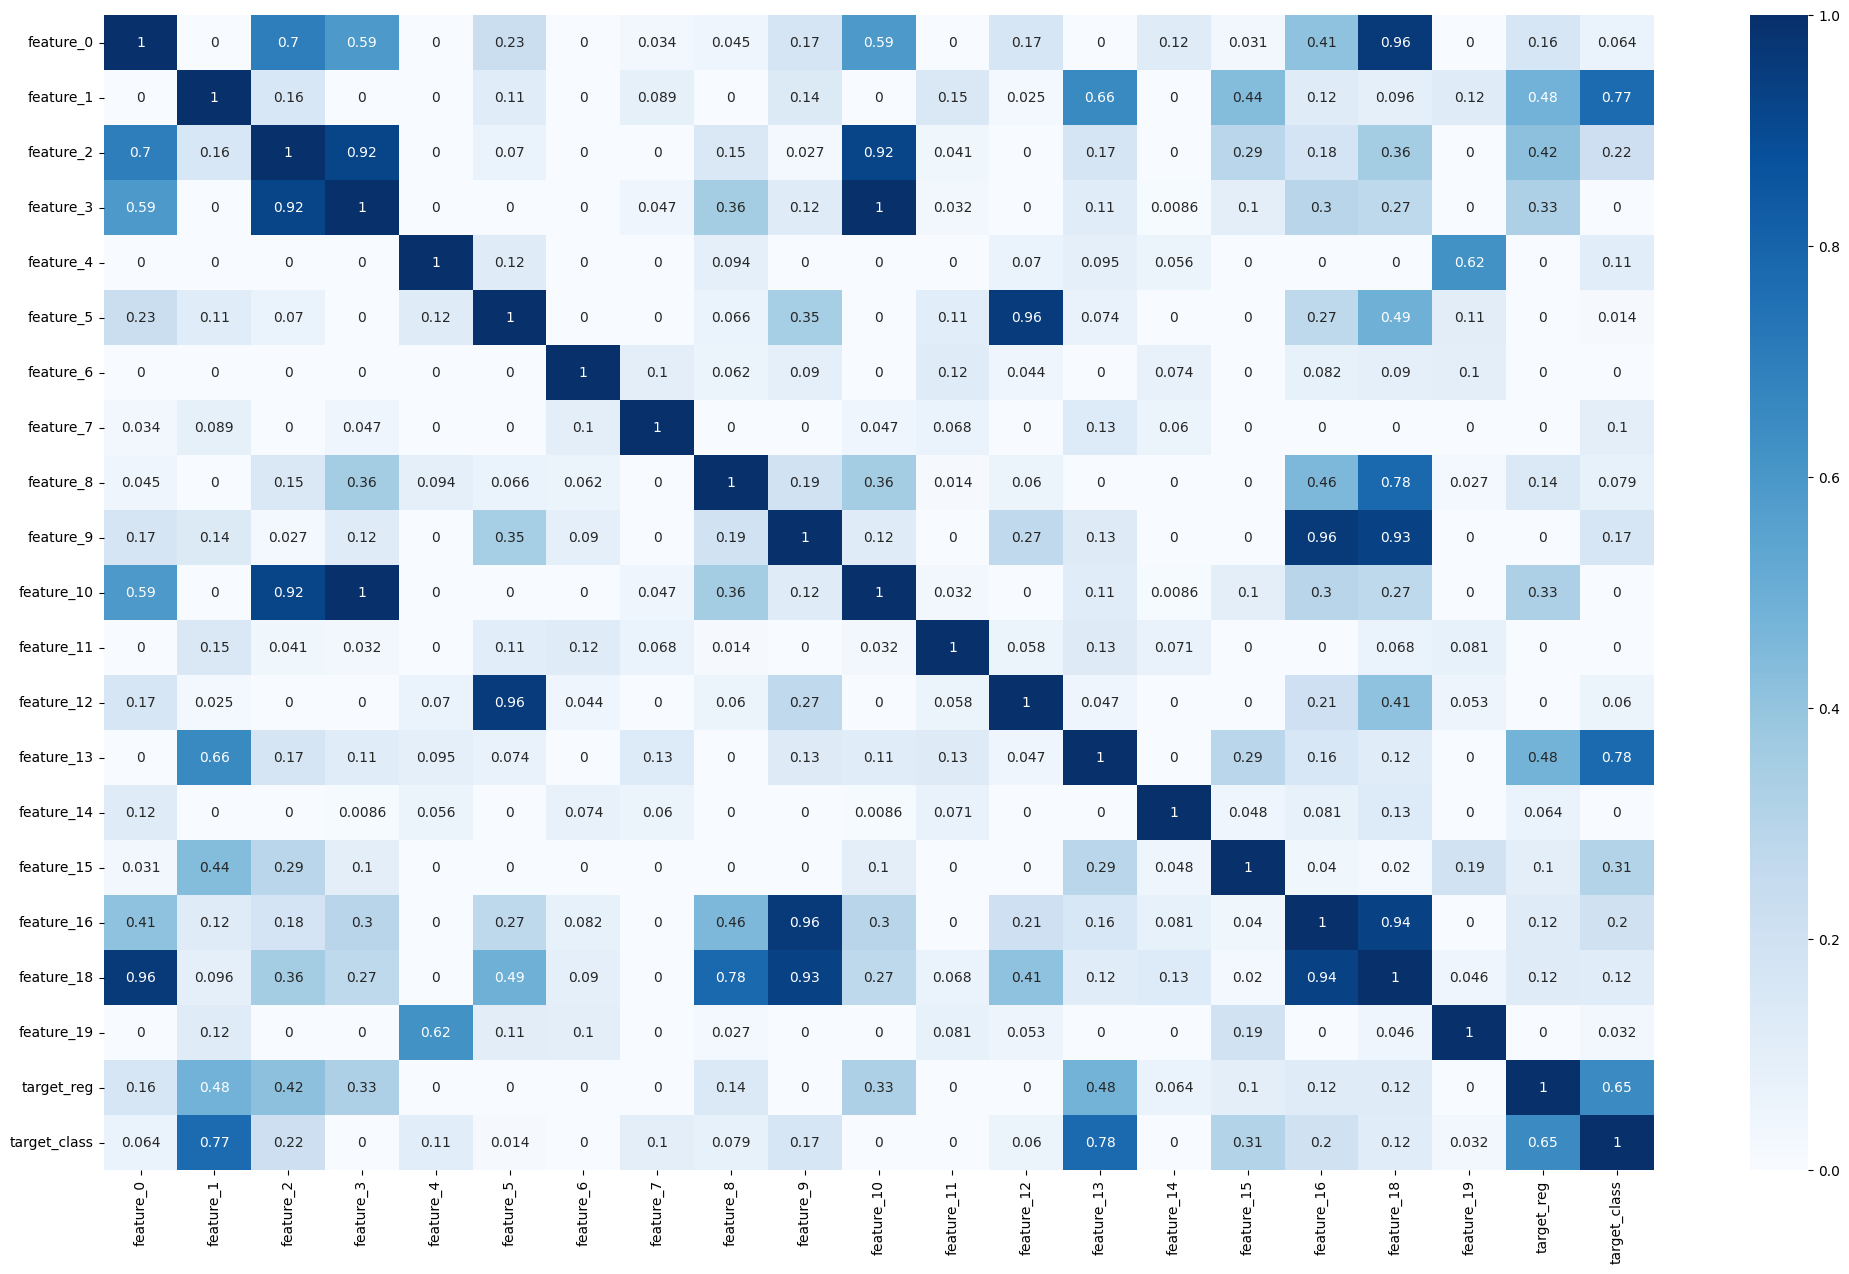

In [126]:
plt.figure(figsize=(25, 15), dpi=100)
interval_columns = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 
                    'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 
                    'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 
                    'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'target_reg']
sns.heatmap(df.phik_matrix(interval_cols=interval_columns), annot=True, cmap='Blues')
plt.show()

In [127]:
phik_overview = df.phik_matrix()

phik_overview[['target_reg', 'target_class']].sort_values(by=['target_reg', 'target_class'], ascending=[1, 1])

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'target_reg']


/opt/anaconda/lib/python3.10/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable feature_17 for analysis 1. Dropping this column
  warnings.warn(


,target_reg,target_class
feature_6,0.000000,0.000000
feature_11,0.000000,0.000000
feature_5,0.000000,0.013657
feature_19,0.000000,0.032438
feature_12,0.000000,0.059520
feature_7,0.000000,0.104469
feature_4,0.000000,0.112559
feature_9,0.000000,0.166869
feature_14,0.064095,0.000000
feature_15,0.103832,0.310957


### Внесите в список answer названия 2-х рандомных признаков
answer = ['feature_6', 'feature_11']